<a id='start'></a>

# Classification Project - Adult Dataset

**Description**

Based on a set of features like age, workclass, education, race etc. determine whether a person makes over 50K a year or less than that. 

**Files**

https://archive.ics.uci.edu/ml/datasets/Adult

**Project author:**

Jakub Gil

This project is split into several segments. If you wish to access any particular one, click on one of the links below.

01. Start [here](#start)

02. Exploratory Data Analysis [here](#eda)

03. Data preprocessing [here](#preprocess)

04. Train test split [here](#train_test)

04. Selecting the best ML algorithm [here](#selecting)

05. Hyperparameter tuning [here](#tuning)

06. Ensemble Learning [here](#ensemble)

06. Final evaluation [here](#final)

07. Feature importance [here](#feature_importance)

07. Is it possible to improve the model? And how? [here](#possible)

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost

# Preprocessing - categorical data
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing - numerical data
from sklearn.preprocessing import StandardScaler

# Train-test split
from sklearn.model_selection import train_test_split

# Model selection
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Ensemble learning
from sklearn.ensemble import VotingClassifier

# Making graphs visible in Jupyter notebook
%matplotlib inline

# Disable warnings
warnings.filterwarnings('ignore')

In [2]:
# Column names

cols = ('Age',
        'Workclass',
        'fnlwgt',
        'Education',
        'Education-num',
        'Marital-status',
        'Occupation',
        'Relationship',
        'Race',
        'Sex',
        'Capital-gain',
        'Capital-loss',
        'Hours-per-week',
        'Native-country',
        'Income')

In [3]:
# Importing the train set

train = pd.read_csv('datasets/adult.data', names=cols)
train.head()

,Age,Workclass,fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Importing the test set

test = pd.read_csv('datasets/adult.test', names=cols)
test = test[1:]
test.head()

,Age,Workclass,fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


In [5]:
# Merging the train and test set for the sake of Exploratory Data Analysis and data preparation

train_test = pd.concat([train,test],axis=0)

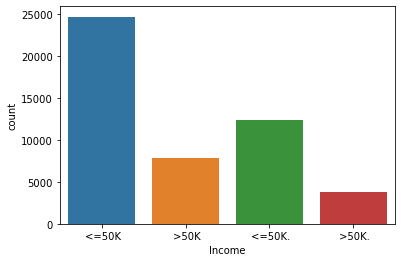

In [6]:
sns.countplot(train_test['Income'])

As we can see above, the income category is a bit messy. In the train set, it's either ' <=50K' or ' >50K', while in the test set: ' <=50K.' or ' >50K.' (with full stops). 

In [7]:
# Cleaning up the Income category

train_test.loc[train_test['Income'] == ' <=50K.', 'Income'] = ' <=50K'
train_test.loc[train_test['Income'] == ' >50K.', 'Income'] = ' >50K'
train_test.loc[train_test['Income'] == '>50K', 'Income'] = ' >50K'

<a id='eda'></a>

# EDA - Exploratory Data Analysis

## How long do men and women work?

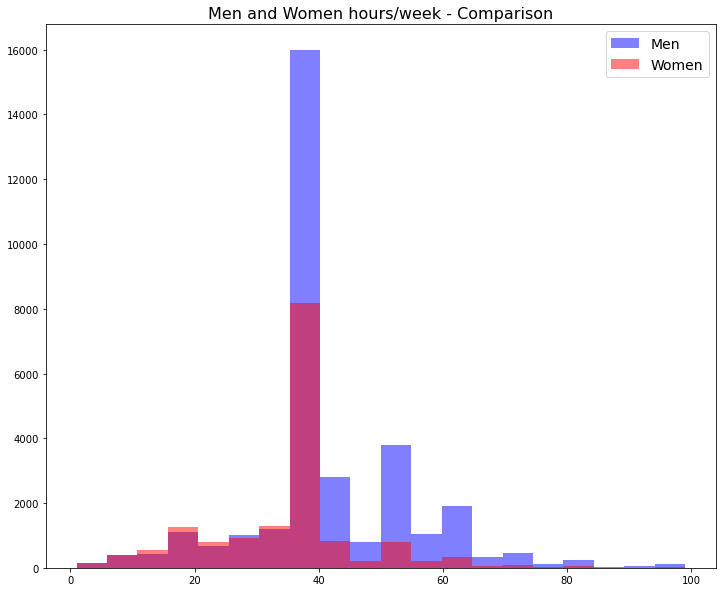

In [8]:
plt.figure(figsize=(12,10))
plt.title('Men and Women hours/week - Comparison',fontsize=16)
plt.hist(train_test[train_test['Sex']==' Male']['Hours-per-week'],bins=20,color='blue',alpha=0.5,label='Men')
plt.hist(train_test[train_test['Sex']==' Female']['Hours-per-week'],bins=20,color='red',alpha=0.5,label='Women')

plt.legend(fontsize=14)

In the vast majority of cases, both men and women work a little less than 40 hours per week. When it comes to the 40-70-hour working week, more men tend to work that much, however in the areas of 10-40 hours, it is women who more usually fall under that category. 

All of this is of course %-wise, relatively to the size of each respective gender category. It would be a mistake to compare absolute numbers here since in the case of men there's more data samples than in the case of women.

This is demonstrated below:

 Male      32650
 Female    16192
Name: Sex, dtype: int64

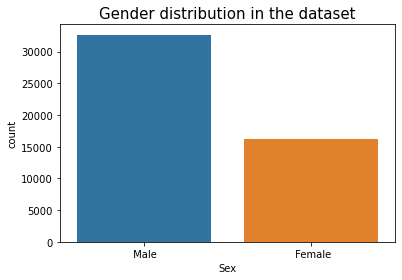

In [9]:
plt.title('Gender distribution in the dataset',fontsize=15)
sns.countplot(train_test['Sex'])

train_test['Sex'].value_counts()

## How much do men and women make?

(array([    0.,  5000., 10000., 15000., 20000., 25000.]),
 <a list of 6 Text major ticklabel objects>)

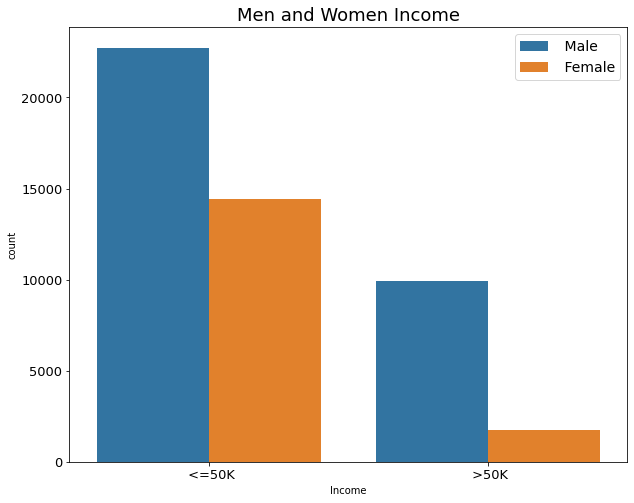

In [10]:
plt.figure(figsize=(10,8))
sns.countplot(train_test['Income'],hue=train_test['Sex'])
plt.title('Men and Women Income',fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [11]:
print('Male Income:')
print(train_test[train_test['Sex'] == ' Male']['Income'].value_counts())

print('\n')

print('Female Income:')
print(train_test[train_test['Sex'] == ' Female']['Income'].value_counts())

Male Income:
 <=50K    22732
 >50K      9918
Name: Income, dtype: int64


Female Income:
 <=50K    14423
 >50K      1769
Name: Income, dtype: int64


In [12]:
men_over_50k_percent = np.round(100*(train_test[train_test['Sex'] == ' Male']['Income'].value_counts()[1])/len(train_test[train_test['Sex'] == ' Male']['Income']),2)
women_over_50k_percent = np.round(100*(train_test[train_test['Sex'] == ' Female']['Income'].value_counts()[1])/len(train_test[train_test['Sex'] == ' Female']['Income']),2)

print('MALE AND FEMALE INCOME (%):')
print('Out of all men, ', men_over_50k_percent, '% earn over 50k.')
print('Out of all women, ', women_over_50k_percent, '% earn over 50k.')

MALE AND FEMALE INCOME (%):
Out of all men,  30.38 % earn over 50k.
Out of all women,  10.93 % earn over 50k.


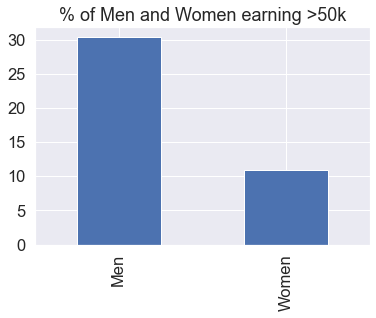

In [13]:
income_gender_metrics = pd.DataFrame({'Men': men_over_50k_percent,
                                     'Women': women_over_50k_percent},
                                    index=['Income'])

sns.set(font_scale=1.5)
income_gender_metrics.T.plot.bar(title='% of Men and Women earning >50k',legend=False)
sns.set()

Generally for the whole population, people tend to earn less than 50k. However, when we break this down, we can see that in the case of men the % of people earning over 50k is around 3x larger than in the case of women. This can be correlated with what has been demonstrated before: the fact that men tend to work longer hours but also with a higher hour rate for men. However, since there's no data on the hour rate, let's only make a connection between the earnings and the working hours.

## Does race influence earnings?

In [14]:
train_test['Race'].unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

First, let's look at the race distribution in the dataset. This is particularly important since in the case of the races with very few examples the data is not as telling as when we have more data samples to work with. For example, if one group has 50k+ examples and the other only 2k, the other group's sample set is simply not large enough to form conclusions with the same certainty as in the bigger sample set. 

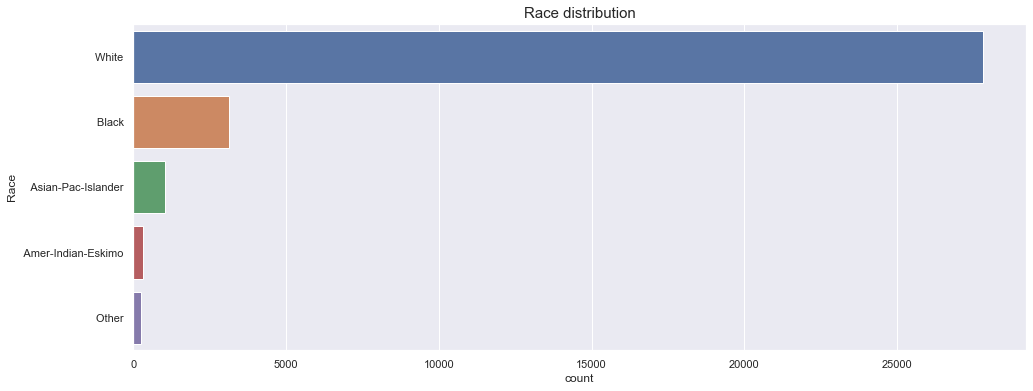

In [15]:
# Race distribution in the dataset

plt.figure(figsize=(16,6))
plt.title('Race distribution',fontsize=15)
sns.countplot(y=train['Race'])

In [16]:
# White people

print('White people that earn over 50k:')
white_over_50k_nom = train_test[train_test['Race'] == ' White']['Income'].value_counts()[1]
print(white_over_50k_nom)
print('Total number of White people in the dataset:')
white_total = len(train_test[train_test['Race'] == ' White'])
print(white_total)
print('White people that earn over 50k (%):')
white_over_50k_per = np.round(100*(white_over_50k_nom/white_total),2)
print(white_over_50k_per, '%')

print('\n')

# Black people

print('Black people that earn over 50k:')
black_over_50k_nom = train_test[train_test['Race'] == ' Black']['Income'].value_counts()[1]
print(black_over_50k_nom)
print('Total number of Black people in the dataset:')
black_total = len(train_test[train_test['Race'] == ' Black'])
print(black_total)
print('Black people that earn over 50k (%):')
black_over_50k_per = np.round(100*(black_over_50k_nom/black_total),2)
print(black_over_50k_per, '%')

print('\n')

# Asian-Pac-Islander

print('Asian-Pac-Islander people that earn over 50k:')
asian_over_50k_nom = train_test[train_test['Race'] == ' Asian-Pac-Islander']['Income'].value_counts()[1]
print(asian_over_50k_nom)
print('Total number of Asian-Pac-Islander people in the dataset:')
asian_total = len(train_test[train_test['Race'] == ' Asian-Pac-Islander'])
print(asian_total)
print('Asian-Pac-Islander people that earn over 50k (%):')
asian_over_50k_per = np.round(100*(asian_over_50k_nom/asian_total),2)
print(asian_over_50k_per, '%')

print('\n')

# Amer-Indian-Eskimo

print('Amer-Indian-Eskimo people that earn over 50k:')
amer_over_50k_nom = train_test[train_test['Race'] == ' Amer-Indian-Eskimo']['Income'].value_counts()[1]
print(amer_over_50k_nom)
print('Total number of Amer-Indian-Eskimo people in the dataset:')
amer_total = len(train_test[train_test['Race'] == ' Amer-Indian-Eskimo'])
print(amer_total)
print('Amer-Indian-Eskimo people that earn over 50k (%):')
amer_over_50k_per = np.round(100*(amer_over_50k_nom/amer_total),2)
print(amer_over_50k_per, '%')

print('\n')

# Other

print('Other people that earn over 50k:')
other_over_50k_nom = train_test[train_test['Race'] == ' Other']['Income'].value_counts()[1]
print(other_over_50k_nom)
print('Total number of Other people in the dataset:')
other_total = len(train_test[train_test['Race'] == ' Other'])
print(other_total)
print('Other people that earn over 50k (%):')
other_over_50k_per = np.round(100*(other_over_50k_nom/other_total),2)
print(other_over_50k_per, '%')

White people that earn over 50k:
10607
Total number of White people in the dataset:
41762
White people that earn over 50k (%):
25.4 %


Black people that earn over 50k:
566
Total number of Black people in the dataset:
4685
Black people that earn over 50k (%):
12.08 %


Asian-Pac-Islander people that earn over 50k:
409
Total number of Asian-Pac-Islander people in the dataset:
1519
Asian-Pac-Islander people that earn over 50k (%):
26.93 %


Amer-Indian-Eskimo people that earn over 50k:
55
Total number of Amer-Indian-Eskimo people in the dataset:
470
Amer-Indian-Eskimo people that earn over 50k (%):
11.7 %


Other people that earn over 50k:
50
Total number of Other people in the dataset:
406
Other people that earn over 50k (%):
12.32 %


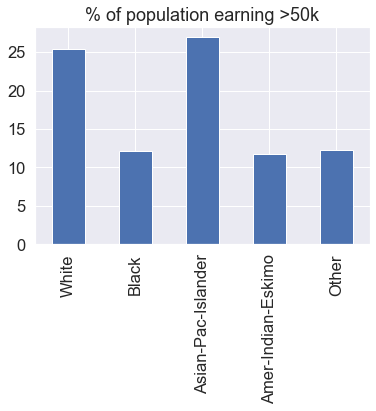

In [17]:
income_metrics = pd.DataFrame({'White': white_over_50k_per,
                             'Black': black_over_50k_per,
                             'Asian-Pac-Islander': asian_over_50k_per,
                             'Amer-Indian-Eskimo': amer_over_50k_per,
                             'Other': other_over_50k_per},
                             index=['% (>50k)'])
sns.set(font_scale=1.5)
income_metrics.T.plot.bar(title='% of population earning >50k',legend=False)
sns.set()

This could also be presented in tabular form:

In [18]:
income_metrics.T.sort_values(by=['% (>50k)'],ascending=False)

,% (>50k)
Asian-Pac-Islander,26.93
White,25.40
Other,12.32
Black,12.08
Amer-Indian-Eskimo,11.70


We can see that around 25% white and Asian-Pac-Islander people earn over 50k while Black, Amer-Indian-Eskimo and Other people are somewhere between 11-13%. 

It is very important to note how much data on each race we have and also take that into account. **In the case of Asian-Pac-Islander, Amer-Indian-Eskimo and Other people there's very little data in comparison to White and Black people (but White in particular) so the % we got for them should not be considered as seriously.**

<a id='preprocess'></a>

# Data preprocessing

## Null objects and Outliers

In [19]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16281
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             48842 non-null  object 
 1   Workclass       48842 non-null  object 
 2   fnlwgt          48842 non-null  float64
 3   Education       48842 non-null  object 
 4   Education-num   48842 non-null  float64
 5   Marital-status  48842 non-null  object 
 6   Occupation      48842 non-null  object 
 7   Relationship    48842 non-null  object 
 8   Race            48842 non-null  object 
 9   Sex             48842 non-null  object 
 10  Capital-gain    48842 non-null  float64
 11  Capital-loss    48842 non-null  float64
 12  Hours-per-week  48842 non-null  float64
 13  Native-country  48842 non-null  object 
 14  Income          48842 non-null  object 
dtypes: float64(5), object(10)
memory usage: 7.2+ MB


There are no null objects/missing data in the dataset, however it seems there's a lot 0 values in the 'Capital-gain' and 'Capital-loss' categories.

In [20]:
print('Number of 0 values in Capital-gain: ', len(train_test[train_test['Capital-gain'] == 0]))
print('Total number of values in Capital-gain: ', len(train_test))
print('% of 0 values in Capital-gain: ', np.round(100*len(train_test[train_test['Capital-gain'] == 0])/len(train_test),2))

print('\n')

print('Number of 0 values in Capital-gain: ', len(train_test[train_test['Capital-loss'] == 0]))
print('Total number of values in Capital-loss: ', len(train_test))
print('% of 0 values in Capital-loss: ', np.round(100*len(train_test[train_test['Capital-loss'] == 0])/len(train_test),2))

Number of 0 values in Capital-gain:  44807
Total number of values in Capital-gain:  48842
% of 0 values in Capital-gain:  91.74


Number of 0 values in Capital-gain:  46560
Total number of values in Capital-loss:  48842
% of 0 values in Capital-loss:  95.33


Text(0.5, 1.0, 'Capital-loss')

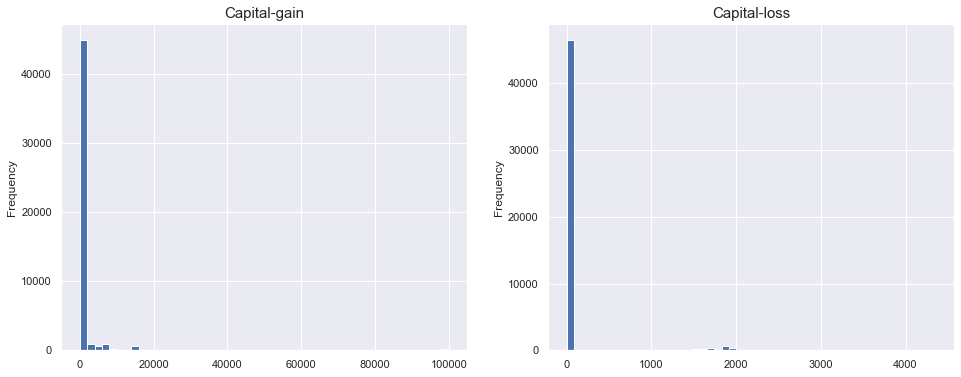

In [21]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
train_test['Capital-gain'].plot.hist(bins=50)
plt.title('Capital-gain',fontsize=15)
train_test_cuts = pd.cut(train_test['Capital-gain'], 5)

plt.subplot(1,2,2)
train_test['Capital-loss'].plot.hist(bins=50)
plt.title('Capital-loss',fontsize=15)

There seem to be a lot of 0 values for Capital-gain and Capital-loss. With over 90% 0 values in both categories, it could be a case of missing data. If it really is missing data, usually both the Capital-gain and the Capital-loss categories would be dropped. For now, however, they are best left as they are.

## Features split - categorical and numerical

In [22]:
# Splitting the data into numerical and categorical attributes

train_test_num = train_test[['Age', 'fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss', 'Hours-per-week']]
train_test_cat = train_test[['Workclass','Education','Marital-status','Occupation','Relationship','Race','Sex','Native-country','Income']]

## Encoding the categorical data

In otder for the ML algorithm to perform better, it's a good practice to encode the categorical data.

In [23]:
train_test_cat

,Workclass,Education,Marital-status,Occupation,Relationship,Race,Sex,Native-country,Income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...
16277,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,United-States,<=50K
16278,?,HS-grad,Widowed,?,Other-relative,Black,Male,United-States,<=50K
16279,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
16280,Private,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,United-States,<=50K


There are 2 ways in which we're going to encode the categorical data: label encoding and one-hot encoding. Upon analysing the categorical data, here's which features we are going to encode in what way:

**Ordinal encoding:**

Feature 1 - Education (ordinal feature, assign by yourself, not alphabetically)

Feature 8 (output feature) - Income

**One-hot encoding:**

Feature 0 - Workclass

Feature 2 - Marital-status

Feature 3 - Occupation

Feature 4 - Relationship *(we will not simplify this feature as it doesn't have that many unique classes)*

Feature 5 - Race *(we will not simplify this feature as it doesn't have that many unique classes)*

Feature 6 - Sex

Feature 7 - Native-country

To make the computations easier for the ML algorithm, the features with many unique classes should be simplified. The fewer classes, the better. Of course we don't want to oversimplify and lose important information in the process.

## Simplifying the features (for easier encoding and faster computation times)

In [24]:
# Creating a data frame that will contain the simplified features (with fewer unique classes)

train_test_bin = pd.DataFrame()

In [25]:
# Simplifying Feature 0 - workclass

train_test.loc[train_test['Workclass'] == ' Without-pay', 'Workclass'] = 'Non-worker'
train_test.loc[train_test['Workclass'] == ' Never-worked', 'Workclass'] = 'Non-worker'
train_test.loc[train_test['Workclass'] == ' State-gov', 'Workclass'] = 'Government'
train_test.loc[train_test['Workclass'] == ' Federal-gov', 'Workclass'] = 'Government'
train_test.loc[train_test['Workclass'] == ' Local-gov', 'Workclass'] = 'Government'
train_test.loc[train_test['Workclass'] == ' Local-gov Workclass', 'Workclass'] = 'Government'
train_test.loc[train_test['Workclass'] == ' Self-emp-not-inc', 'Workclass'] = 'Self-emp'
train_test.loc[train_test['Workclass'] == ' Self-emp-inc', 'Workclass'] = 'Self-emp'
train_test.loc[train_test['Workclass'] == ' ?', 'Workclass'] = 'Unknown-Workclass'

train_test_bin['Workclass'] = train_test['Workclass']

Text(0.5, 1.0, 'Workclass - Simplified')

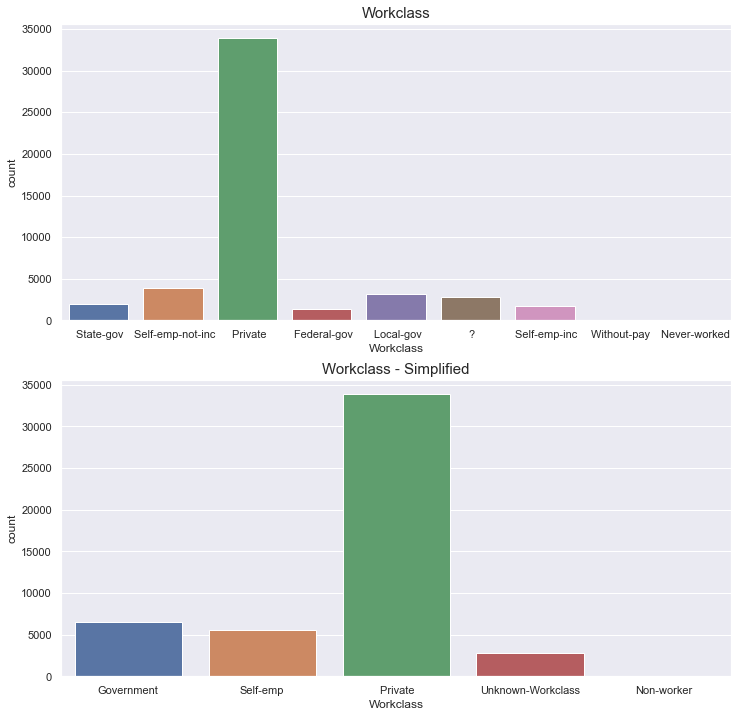

In [26]:
plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
sns.countplot(train_test_cat['Workclass'])
plt.title('Workclass', fontsize=15)

plt.subplot(2,1,2)
sns.countplot(train_test_bin['Workclass'])
plt.title('Workclass - Simplified', fontsize=15)

In [27]:
# Adding Feagure 1 - Education (we don't simplify this feature)

train_test_bin['Education'] = train_test['Education']

In [28]:
# Simplifying Feature 2 - Marital-status

train_test.loc[train_test['Marital-status'] == ' Divorced', 'Marital-status'] = 'Separated'
train_test.loc[train_test['Marital-status'] == ' Separated', 'Marital-status'] = 'Separated'
train_test.loc[train_test['Marital-status'] == ' Married-civ-spouse', 'Marital-status'] = 'Married'
train_test.loc[train_test['Marital-status'] == ' Married-AF-spouse', 'Marital-status'] = 'Married'

train_test_bin['Marital-status'] = train_test['Marital-status']

Text(0.5, 1.0, 'Marital-status Simplified')

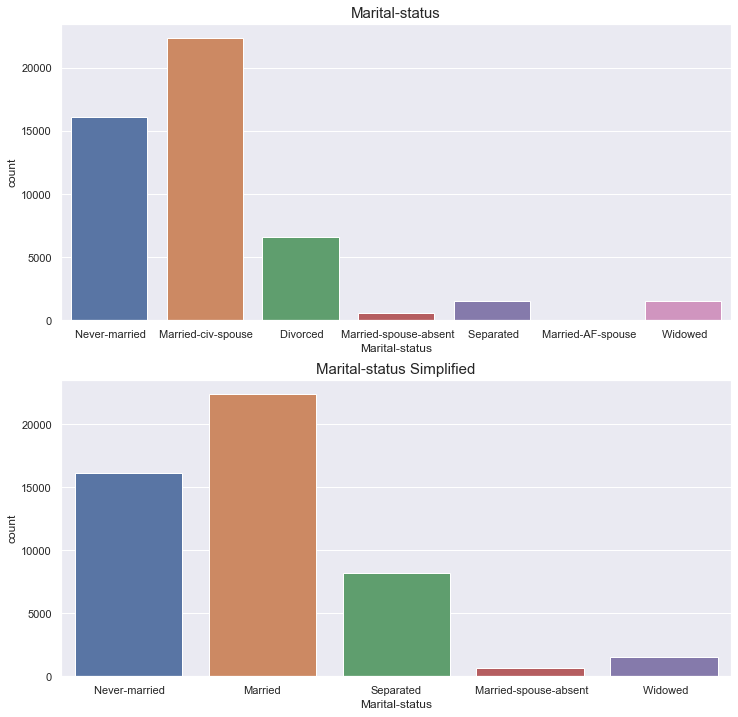

In [29]:
plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
sns.countplot(train_test_cat['Marital-status'])
plt.title('Marital-status',fontsize=15)

plt.subplot(2,1,2)
sns.countplot(train_test_bin['Marital-status'])
plt.title('Marital-status Simplified',fontsize=15)

In [30]:
# Simplifying feature 3 - Occupation

train_test.loc[train_test['Occupation'] == ' Adm-clerical', 'Occupation'] = 'Admin'
train_test.loc[train_test['Occupation'] == ' Armed-Forces', 'Occupation'] = 'Military'
train_test.loc[train_test['Occupation'] == ' Protective-serv', 'Occupation'] = 'Military'
train_test.loc[train_test['Occupation'] == ' Exec-managerial', 'Occupation'] = 'Office'
train_test.loc[train_test['Occupation'] == ' Tech-support', 'Occupation'] = 'Office'
train_test.loc[train_test['Occupation'] == ' Sales', 'Occupation'] = 'Office'
train_test.loc[train_test['Occupation'] == ' Craft-repair', 'Occupation'] = 'Manual'
train_test.loc[train_test['Occupation'] == ' Farming-fishing', 'Occupation'] = 'Manual'
train_test.loc[train_test['Occupation'] == ' Handlers-cleaners', 'Occupation'] = 'Manual'
train_test.loc[train_test['Occupation'] == ' Machine-op-inspct', 'Occupation'] = 'Manual'
train_test.loc[train_test['Occupation'] == ' Transport-moving', 'Occupation'] = 'Manual'
train_test.loc[train_test['Occupation'] == ' Other-service', 'Occupation'] = 'Service'
train_test.loc[train_test['Occupation'] == ' Priv-house-serv', 'Occupation'] = 'Service'
train_test.loc[train_test['Occupation'] == ' Prof-specialty', 'Occupation'] = 'Professional'
train_test.loc[train_test['Occupation'] == ' ?', 'Occupation'] = 'Unknown-Occupation'

train_test_bin['Occupation'] = train_test['Occupation']

Text(0.5, 1.0, 'Occupation Simplified')

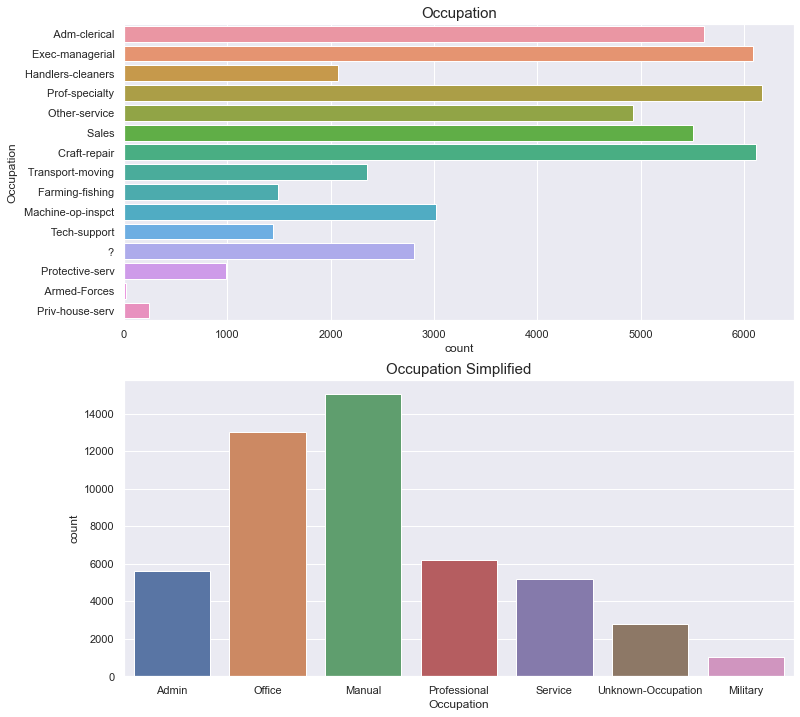

In [31]:
plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
sns.countplot(y=train_test_cat['Occupation'])
plt.title('Occupation', fontsize=15)

plt.subplot(2,1,2)
sns.countplot(train_test_bin['Occupation'])
plt.title('Occupation Simplified', fontsize=15)

In [32]:
# Adding feature 4 - Relationship

train_test_bin['Relationship'] = train_test_cat['Relationship']

# Adding feature 5 - Race

train_test_bin['Race'] = train_test_cat['Race']

# Adding feature 6 - Sex 

train_test_bin['Sex'] = train_test_cat['Sex']

In [33]:
# Simplifying feature 7

# USA (due to the relative importance in the dataset USA is not paired together with the rest of North-America)
# Instead, it's a separate category.
train_test.loc[train_test['Native-country'] == ' United-States', 'Native-country'] = 'USA'

# Europe
train_test.loc[train_test['Native-country'] == ' Germany', 'Native-country'] = 'Europe'
train_test.loc[train_test['Native-country'] == ' England', 'Native-country'] = 'Europe'
train_test.loc[train_test['Native-country'] == ' Italy', 'Native-country'] = 'Europe'
train_test.loc[train_test['Native-country'] == ' Poland', 'Native-country'] = 'Europe'
train_test.loc[train_test['Native-country'] == ' Portugal', 'Native-country'] = 'Europe'
train_test.loc[train_test['Native-country'] == ' Greece', 'Native-country'] = 'Europe'
train_test.loc[train_test['Native-country'] == ' France', 'Native-country'] = 'Europe'
train_test.loc[train_test['Native-country'] == ' Ireland', 'Native-country'] = 'Europe'
train_test.loc[train_test['Native-country'] == ' Yugoslavia', 'Native-country'] = 'Europe'
train_test.loc[train_test['Native-country'] == ' Hungary', 'Native-country'] = 'Europe'
train_test.loc[train_test['Native-country'] == ' Scotland', 'Native-country'] = 'Europe'
train_test.loc[train_test['Native-country'] == ' Holand-Netherlands', 'Native-country'] = 'Europe'

# North America
train_test.loc[train_test['Native-country'] == ' Mexico', 'Native-country'] = 'North-America'
train_test.loc[train_test['Native-country'] == ' Canada', 'Native-country'] = 'North-America'
train_test.loc[train_test['Native-country'] == ' Puerto-Rico', 'Native-country'] = 'North-America'
train_test.loc[train_test['Native-country'] == ' Cuba', 'Native-country'] = 'North-America'
train_test.loc[train_test['Native-country'] == ' Jamaica', 'Native-country'] = 'North-America'
train_test.loc[train_test['Native-country'] == ' Dominican-Republic', 'Native-country'] = 'North-America'
train_test.loc[train_test['Native-country'] == ' Outlying-US(Guam-USVI-etc)', 'Native-country'] = 'North-America'

# South America (for the sake of simplicity, every country in Middle America falls uder this category too)
train_test.loc[train_test['Native-country'] == ' El-Salvador', 'Native-country'] = 'South-America'
train_test.loc[train_test['Native-country'] == ' Guatemala', 'Native-country'] = 'South-America'
train_test.loc[train_test['Native-country'] == ' Columbia', 'Native-country'] = 'South-America'
train_test.loc[train_test['Native-country'] == ' Haiti', 'Native-country'] = 'South-America'
train_test.loc[train_test['Native-country'] == ' Nicaragua', 'Native-country'] = 'South-America'
train_test.loc[train_test['Native-country'] == ' Peru', 'Native-country'] = 'South-America'
train_test.loc[train_test['Native-country'] == ' Ecuador', 'Native-country'] = 'South-America'
train_test.loc[train_test['Native-country'] == ' Trinadad&Tobago', 'Native-country'] = 'South-America'
train_test.loc[train_test['Native-country'] == ' Honduras', 'Native-country'] = 'South-America'

# Asia 
train_test.loc[train_test['Native-country'] == ' Philippines', 'Native-country'] = 'Asia'
train_test.loc[train_test['Native-country'] == ' India', 'Native-country'] = 'Asia'
train_test.loc[train_test['Native-country'] == ' South', 'Native-country'] = 'Asia' # we're assuming here it's South Korea
train_test.loc[train_test['Native-country'] == ' China', 'Native-country'] = 'Asia'
train_test.loc[train_test['Native-country'] == ' Vietnam', 'Native-country'] = 'Asia'
train_test.loc[train_test['Native-country'] == ' Japan', 'Native-country'] = 'Asia'
train_test.loc[train_test['Native-country'] == ' Taiwan', 'Native-country'] = 'Asia'
train_test.loc[train_test['Native-country'] == ' Iran', 'Native-country'] = 'Asia'
train_test.loc[train_test['Native-country'] == ' Hong', 'Native-country'] = 'Asia' # we're assuming here it's Hongkong
train_test.loc[train_test['Native-country'] == ' Cambodia', 'Native-country'] = 'Asia'
train_test.loc[train_test['Native-country'] == ' Laos', 'Native-country'] = 'Asia'
train_test.loc[train_test['Native-country'] == ' Thailand', 'Native-country'] = 'Asia'

train_test.loc[train_test['Native-country'] == ' ?', 'Native-country'] = 'Unknown-Country'

train_test_bin['Native-country'] = train_test['Native-country']

Text(0.5, 1.0, 'Native country Simplified - USA and continents')

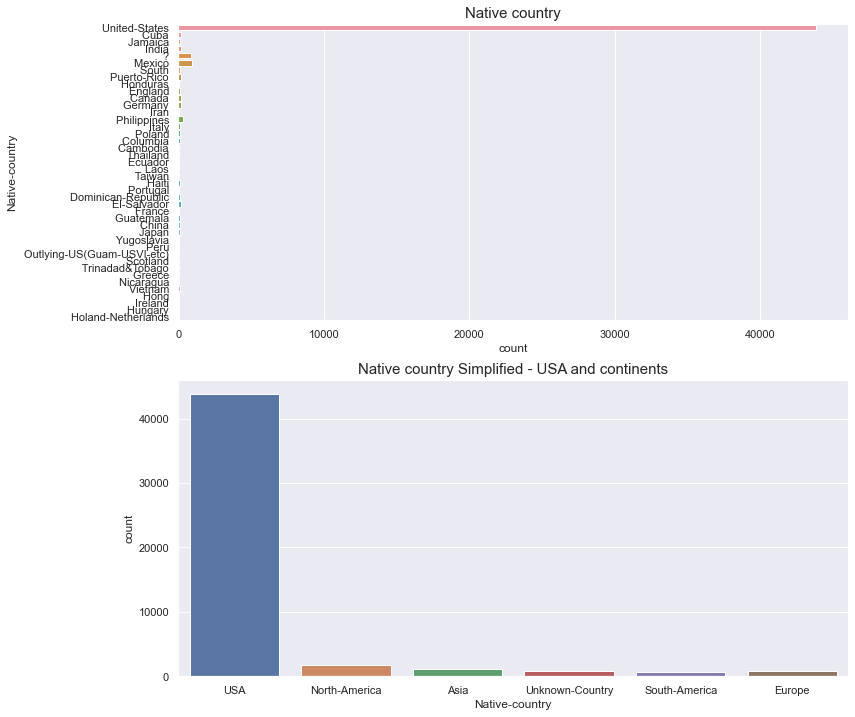

In [34]:
plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
sns.countplot(y=train_test_cat['Native-country'])
plt.title('Native country', fontsize=15)

plt.subplot(2,1,2)
sns.countplot(train_test_bin['Native-country'])
plt.title('Native country Simplified - USA and continents',fontsize=15)

In [35]:
# Adding Feature 8 - Income

train_test_bin['Income'] = train_test_cat['Income']

In [36]:
ct = ColumnTransformer([
                        ('0_Workclass', OneHotEncoder(), ['Workclass']),
                        ('1_Education', OrdinalEncoder(), ['Education']),
                        ('2_Marital-status', OneHotEncoder(), ['Marital-status']),
                        ('3_Occupation', OneHotEncoder(), ['Occupation']),
                        ('4_Relationship', OneHotEncoder(), ['Relationship']),
                        ('5_Race', OneHotEncoder(), ['Race']),
                        ('6_Sex', OrdinalEncoder(), ['Sex']),
                        ('7_Native-country', OneHotEncoder(), ['Native-country']),
                        ('8_Income', OrdinalEncoder(), ['Income'])
                        ])

In [37]:
train_test_bin_encoded = ct.fit_transform(train_test_bin)
train_test_bin_encoded = train_test_bin_encoded.astype(int)

# Create a DataFrame from a sparse matrix
train_test_bin_encoded = pd.DataFrame.sparse.from_spmatrix(train_test_bin_encoded)

# Preview the DataFrame
train_test_bin_encoded.head(10)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0,1,0,0,0,9,0,1,0,0,...,0,1,1,0,0,0,0,1,0,0
1,0,0,0,1,0,9,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
2,1,0,0,0,0,11,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
3,1,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
4,1,0,0,0,0,9,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
5,1,0,0,0,0,12,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
6,1,0,0,0,0,6,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,0,1,0,11,0,0,0,1,...,0,1,1,0,0,0,0,1,0,1
8,1,0,0,0,0,12,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
9,1,0,0,0,0,9,0,0,0,1,...,0,1,1,0,0,0,0,1,0,1


In [38]:
# Getting column names for the encoded data

ordinal_indices = [1,6,8]
one_hot_indices = [0,2,3,4,5,7]

train_test_bin_encoded_col_names = []

def get_encoded_col_names():

    for i in range(len(train_test_bin.columns)):
        
        if i in one_hot_indices:
            #train_test_bin_encoded_col_names.append(train_test_bin.iloc[:,i].unique())
            n = train_test_bin.iloc[:,i].nunique()
            for j in range(n):
                train_test_bin_encoded_col_names.append(train_test_bin.iloc[:,i].unique()[j])
            
            
        elif i in ordinal_indices:
            train_test_bin_encoded_col_names.append(train_test_bin.columns[i])
        
        else:
            print('Error')
            
    return train_test_bin_encoded_col_names

In [39]:
train_test_bin_encoded.columns = get_encoded_col_names()

In [40]:
train_test_bin_encoded.head(10)

,Government,Self-emp,Private,Unknown-Workclass,Non-worker,Education,Never-married,Married,Separated,Married-spouse-absent,...,Amer-Indian-Eskimo,Other,Sex,USA,North-America,Asia,Unknown-Country,South-America,Europe,Income
0,0,1,0,0,0,9,0,1,0,0,...,0,1,1,0,0,0,0,1,0,0
1,0,0,0,1,0,9,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
2,1,0,0,0,0,11,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
3,1,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
4,1,0,0,0,0,9,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
5,1,0,0,0,0,12,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
6,1,0,0,0,0,6,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,0,1,0,11,0,0,0,1,...,0,1,1,0,0,0,0,1,0,1
8,1,0,0,0,0,12,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
9,1,0,0,0,0,9,0,0,0,1,...,0,1,1,0,0,0,0,1,0,1


The labeled columns look much better now. However, there's still a problem: notice how there are at least 2 columns named "?". While in the majority of cases this is not a problem, in the case of XGBoost the features all need to have original names.

Upon inspecting the column names, it turns out there are 3 columns with the same name: " ?". Let's find them:

Now every single column has an original name.

The data presented in the matrix above is nice and easily digestable for the Machine learning algorithms. There are no words, only numbers. Let's now proceed to taking care of the numerical part of the dataset.

## Preparing the numerical data

In [41]:
train_test_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16281
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             48842 non-null  object 
 1   fnlwgt          48842 non-null  float64
 2   Education-num   48842 non-null  float64
 3   Capital-gain    48842 non-null  float64
 4   Capital-loss    48842 non-null  float64
 5   Hours-per-week  48842 non-null  float64
dtypes: float64(5), object(1)
memory usage: 3.9+ MB


Usually it's a good practice to start by looking at the missing values, however in this case as we can see above there really aren't any. Perhaps this is a bit unrealistic but since we're working with a dataset that's neatly prepared, the missing values problem has already been taken care for us.

**Scaling**

In [42]:
train_test_num

,Age,fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week
0,39,77516.0,13.0,2174.0,0.0,40.0
1,50,83311.0,13.0,0.0,0.0,13.0
2,38,215646.0,9.0,0.0,0.0,40.0
3,53,234721.0,7.0,0.0,0.0,40.0
4,28,338409.0,13.0,0.0,0.0,40.0
...,...,...,...,...,...,...
16277,39,215419.0,13.0,0.0,0.0,36.0
16278,64,321403.0,9.0,0.0,0.0,40.0
16279,38,374983.0,13.0,0.0,0.0,50.0
16280,44,83891.0,13.0,5455.0,0.0,40.0


In [43]:
ss = StandardScaler()
train_test_num_scaled = ss.fit_transform(train_test_num)
train_test_num_scaled = pd.DataFrame(train_test_num_scaled)
train_test_num_scaled.columns = train_test_num.columns

train_test_num_scaled

,Age,fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week
0,0.025996,-1.061979,1.136512,0.146932,-0.217127,-0.034087
1,0.828308,-1.007104,1.136512,-0.144804,-0.217127,-2.213032
2,-0.046942,0.246034,-0.419335,-0.144804,-0.217127,-0.034087
3,1.047121,0.426663,-1.197259,-0.144804,-0.217127,-0.034087
4,-0.776316,1.408530,1.136512,-0.144804,-0.217127,-0.034087
...,...,...,...,...,...,...
48837,0.025996,0.243884,1.136512,-0.144804,-0.217127,-0.356894
48838,1.849433,1.247492,-0.419335,-0.144804,-0.217127,-0.034087
48839,-0.046942,1.754865,1.136512,-0.144804,-0.217127,0.772930
48840,0.390683,-1.001612,1.136512,0.587220,-0.217127,-0.034087


Below we can see the data in its final form, the form we are going to feed it to the ML algorithm in:

In [44]:
train_test_final = pd.concat([train_test_bin_encoded,train_test_num_scaled],axis=1)
train_test_final.head(10)

,Government,Self-emp,Private,Unknown-Workclass,Non-worker,Education,Never-married,Married,Separated,Married-spouse-absent,...,Unknown-Country,South-America,Europe,Income,Age,fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week
0,0,1,0,0,0,9,0,1,0,0,...,0,1,0,0,0.025996,-1.061979,1.136512,0.146932,-0.217127,-0.034087
1,0,0,0,1,0,9,0,0,0,1,...,0,1,0,0,0.828308,-1.007104,1.136512,-0.144804,-0.217127,-2.213032
2,1,0,0,0,0,11,0,0,0,0,...,0,1,0,0,-0.046942,0.246034,-0.419335,-0.144804,-0.217127,-0.034087
3,1,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1.047121,0.426663,-1.197259,-0.144804,-0.217127,-0.034087
4,1,0,0,0,0,9,0,0,0,1,...,0,0,0,0,-0.776316,1.408530,1.136512,-0.144804,-0.217127,-0.034087
5,1,0,0,0,0,12,0,0,0,1,...,0,1,0,0,-0.119879,0.898818,1.525474,-0.144804,-0.217127,-0.034087
6,1,0,0,0,0,6,1,0,0,0,...,0,0,0,0,0.755371,-0.279132,-1.975183,-0.144804,-0.217127,-1.970927
7,0,0,0,1,0,11,0,0,0,1,...,0,1,0,1,0.974183,0.189179,-0.419335,-0.144804,-0.217127,0.369421
8,1,0,0,0,0,12,0,1,0,0,...,0,1,0,1,-0.557504,-1.362492,1.525474,1.745173,-0.217127,0.772930
9,1,0,0,0,0,9,0,0,0,1,...,0,1,0,1,0.244808,-0.286120,1.136512,0.550049,-0.217127,-0.034087


In [45]:
X = train_test_final.drop('Income',axis=1)
X

,Government,Self-emp,Private,Unknown-Workclass,Non-worker,Education,Never-married,Married,Separated,Married-spouse-absent,...,Asia,Unknown-Country,South-America,Europe,Age,fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week
0,0,1,0,0,0,9,0,1,0,0,...,0,0,1,0,0.025996,-1.061979,1.136512,0.146932,-0.217127,-0.034087
1,0,0,0,1,0,9,0,0,0,1,...,0,0,1,0,0.828308,-1.007104,1.136512,-0.144804,-0.217127,-2.213032
2,1,0,0,0,0,11,0,0,0,0,...,0,0,1,0,-0.046942,0.246034,-0.419335,-0.144804,-0.217127,-0.034087
3,1,0,0,0,0,1,0,0,0,1,...,0,0,1,0,1.047121,0.426663,-1.197259,-0.144804,-0.217127,-0.034087
4,1,0,0,0,0,9,0,0,0,1,...,1,0,0,0,-0.776316,1.408530,1.136512,-0.144804,-0.217127,-0.034087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,1,0,0,0,0,9,0,0,0,0,...,0,0,1,0,0.025996,0.243884,1.136512,-0.144804,-0.217127,-0.356894
48838,0,0,0,0,1,11,0,0,1,0,...,0,0,1,0,1.849433,1.247492,-0.419335,-0.144804,-0.217127,-0.034087
48839,1,0,0,0,0,9,0,0,0,1,...,0,0,1,0,-0.046942,1.754865,1.136512,-0.144804,-0.217127,0.772930
48840,1,0,0,0,0,9,0,0,0,0,...,0,0,1,0,0.390683,-1.001612,1.136512,0.587220,-0.217127,-0.034087


In [46]:
y = train_test_final['Income']
y

0        0
1        0
2        0
3        0
4        0
        ..
48837    0
48838    0
48839    0
48840    0
48841    1
Name: Income, Length: 48842, dtype: Sparse[int32, 0]

<a id='train_test'></a>

# Train test split

Even though the data was already split at first, I had to join it together for the purpose of Exploratory Data Analysis and Preprocessing. Now I'm going to split it back again.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
X_train.head()

,Government,Self-emp,Private,Unknown-Workclass,Non-worker,Education,Never-married,Married,Separated,Married-spouse-absent,...,Asia,Unknown-Country,South-America,Europe,Age,fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week
45526,1,0,0,0,0,11,0,0,0,1,...,0,0,1,0,1.047121,0.095223,-0.419335,-0.144804,-0.217127,-0.034087
10815,0,1,0,0,0,15,0,0,0,1,...,0,0,1,0,-0.119879,-0.913224,-0.030373,0.886874,-0.217127,-0.034087
6404,0,0,0,1,0,11,0,1,0,0,...,0,0,1,0,-1.359816,-0.886975,-0.419335,-0.144804,-0.217127,2.386963
1555,1,0,0,0,0,2,0,0,0,0,...,0,0,1,0,0.390683,-0.476560,-0.808297,-0.144804,-0.217127,-0.034087
17187,0,1,0,0,0,11,0,0,0,0,...,0,0,1,0,1.411808,1.031968,-0.419335,-0.144804,-0.217127,-0.034087


In [49]:
y_train.head()

45526    1
10815    1
6404     0
1555     0
17187    0
Name: Income, dtype: Sparse[int32, 0]

<a id='selecting'></a>

# Selecting the best ML algorithm

Firsly, I'm going to quickly look at a selection of Machine Learning algorithms. I'm not going to do any hyperparameter tuning or in-depth analysis. 

For this I also won't use the test set (which will be used to verify hyperparameters later down the line). Instead, I'm going to use a cross-validation set, with a 5-fold cross validation.

### Logistic Regression

In [50]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

In [51]:
log_reg_cv_acc = cross_val_score(log_reg,X_train,y_train,cv=5,scoring='accuracy')
log_reg_cv_acc

array([0.85118362, 0.85105566, 0.8481126 , 0.85436396, 0.85014077])

In [52]:
log_reg_cv_acc_mean = np.round(np.mean(log_reg_cv_acc),4)
log_reg_cv_acc_mean

0.851

### SGD Classifier

In [53]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train,y_train)

SGDClassifier()

In [54]:
sgd_clf_acc = cross_val_score(sgd_clf,X_train,y_train,cv=5,scoring='accuracy')
sgd_clf_acc

array([0.8481126 , 0.84644914, 0.84888036, 0.8515485 , 0.83273611])

In [55]:
sgd_clf_acc_mean = np.round(np.mean(sgd_clf_acc),4)
sgd_clf_acc_mean

0.8455

### KNeighbors Classifier

In [56]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_train)

KNeighborsClassifier()

In [57]:
knn_clf_acc = cross_val_score(knn_clf,X_train,y_train,cv=5,scoring='accuracy')
knn_clf_acc

array([0.82776711, 0.82904671, 0.83071017, 0.83465575, 0.83823906])

In [58]:
knn_clf_acc_mean = np.round(np.mean(knn_clf_acc),4)
knn_clf_acc_mean

0.8321

### Decision tree

In [59]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [60]:
dt_clf_acc = cross_val_score(dt_clf,X_train,y_train,cv=5,scoring='accuracy')
dt_clf_acc

array([0.81087652, 0.81765835, 0.80754958, 0.8130279 , 0.81929869])

In [61]:
dt_clf_acc_mean = np.round(np.mean(dt_clf_acc),4)
dt_clf_acc_mean

0.8137

### Random Forest

In [62]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

RandomForestClassifier()

In [63]:
rf_clf_acc = cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='accuracy')
rf_clf_acc

array([0.84888036, 0.85502239, 0.85028791, 0.85231636, 0.85295623])

In [64]:
rf_clf_acc_mean = np.round(np.mean(rf_clf_acc),4)
rf_clf_acc_mean

0.8519

### Gradient Boosting

In [65]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train,y_train)

GradientBoostingClassifier()

In [66]:
gb_clf_acc = cross_val_score(gb_clf,X_train,y_train,cv=5,scoring='accuracy')
gb_clf_acc

array([0.86359565, 0.86845809, 0.86692258, 0.86524187, 0.86946506])

In [67]:
gb_clf_acc_mean = np.round(np.mean(gb_clf_acc),4)
gb_clf_acc_mean

0.8667

### XG Boost

In [68]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
xgb_clf_acc = cross_val_score(xgb_clf,X_train,y_train,cv=5,scoring='accuracy')
xgb_clf_acc

array([0.86513116, 0.86948177, 0.86922585, 0.8661377 , 0.8734323 ])

In [70]:
xgb_clf_acc_mean = np.round(np.mean(xgb_clf_acc),4)
xgb_clf_acc_mean

0.8687

### Preliminary analysis - Summary

In [71]:
model_accuracies = pd.DataFrame({'Logistic Regression':log_reg_cv_acc_mean,
                                 'SGD':sgd_clf_acc_mean,
                              'KNeighbors':knn_clf_acc_mean,
                              'Decision tree':dt_clf_acc_mean,   
                              'Random Forest':rf_clf_acc_mean,
                                 'Gradient Boosting' :gb_clf_acc_mean,
                                 'XGBoost' :xgb_clf_acc_mean
                                },index=['Score'])

model_accuracies = 100*model_accuracies.T.sort_values(by=['Score'],ascending=False)
model_accuracies

,Score
XGBoost,86.87
Gradient Boosting,86.67
Random Forest,85.19
Logistic Regression,85.10
SGD,84.55
KNeighbors,83.21
Decision tree,81.37


I'm going to tune the hyperparameters for top 4 best algorithms - XGBoost, Gradient Boosting, Logistic Regression and Random Forest.

<a id='tuning'></a>

# Hyperparameter tuning

### XGBoost

In [72]:
params_xgb = [{'max_depth': np.linspace(3,10,8).astype(int),
              'min_child_weight': [0,0.25,0.5,0.75,1,1.25]
              }]

gridsearch_xgb = GridSearchCV(xgb_clf,
                             param_grid=params_xgb,
                             scoring='accuracy'
                             )

xgb_clf_gridsearch = gridsearch_xgb.fit(X_train,y_train)

print(xgb_clf_gridsearch.best_params_)
print(xgb_clf_gridsearch.best_score_)

{'max_depth': 4, 'min_child_weight': 0.5}
0.8717784785449153


In [73]:
# Putting together accuracies - before and after hyperparameter tuning

xgb_clf_accuracies = pd.DataFrame({'Original model': xgb_clf_acc_mean,
                                   'After hyperparameter tuning' : np.round(xgb_clf_gridsearch.best_score_,4),
                                    },index=['Accuracy'])

# Calculating accuracy improvement caused by hyperparameter tuning

xgb_clf_improvement = 100*(np.round(xgb_clf_gridsearch.best_score_,4)-xgb_clf_acc_mean)/xgb_clf_acc_mean
xgb_clf_improvement = np.round(xgb_clf_improvement,2)

# Presenting the results

print('XGBOOST:')
print(xgb_clf_accuracies.T.sort_values(by='Accuracy',ascending=False))
print('\n')
print(xgb_clf_improvement, '% performance improvement (with hyperparameter tuning).')

XGBOOST:
                             Accuracy
After hyperparameter tuning    0.8718
Original model                 0.8687


0.36 % performance improvement (with hyperparameter tuning).


### Gradient Boosting

In [74]:
params_gb = [{'learning_rate' : [1, 0.5, 0.3, 0.1, 0.03, 0.01], 
              'n_estimators' : list(range(10, 131, 40))                
            }]

gridsearch_gb = GridSearchCV(gb_clf,
                            param_grid=params_gb,
                            scoring='accuracy'
                            )

gb_clf_gridsearch = gridsearch_gb.fit(X_train,y_train)

print(gb_clf_gridsearch.best_params_)
print(gb_clf_gridsearch.best_score_)

{'learning_rate': 0.5, 'n_estimators': 50}
0.8708827258717189


In [75]:
# Putting together accuracies - before and after hyperparameter tuning

gb_clf_accuracies = pd.DataFrame({'Original model': gb_clf_acc_mean,
                                   'After hyperparameter tuning' : np.round(gb_clf_gridsearch.best_score_,4),
                                    },index=['Accuracy'])

# Calculating accuracy improvement caused by hyperparameter tuning

gb_clf_improvement = 100*(np.round(gb_clf_gridsearch.best_score_,4)-gb_clf_acc_mean)/gb_clf_acc_mean
gb_clf_improvement = np.round(gb_clf_improvement,2)

# Presenting the results

print('GRADIENT BOOSTING:')
print(gb_clf_accuracies.T.sort_values(by='Accuracy',ascending=False))
print('\n')
print(gb_clf_improvement, '% pegbormance improvement (with hyperparameter tuning).')

GRADIENT BOOSTING:
                             Accuracy
After hyperparameter tuning    0.8709
Original model                 0.8667


0.48 % pegbormance improvement (with hyperparameter tuning).


### Random Forest

In [76]:
params_rf = [{'n_estimators': list(range(50,101,5)),
             'max_features': list(range(6,32,5))
             }]

gridsearch_rf = GridSearchCV(rf_clf,
                            param_grid=params_rf,
                            scoring='accuracy'
                            )

rf_clf_gridsearch = gridsearch_rf.fit(X_train,y_train)

print(rf_clf_gridsearch.best_params_)
print(rf_clf_gridsearch.best_score_)

{'max_features': 26, 'n_estimators': 95}
0.8558340665514805


In [77]:
# Putting together accuracies - before and after hyperparameter tuning

rf_clf_accuracies = pd.DataFrame({'Original model': rf_clf_acc_mean,
                                   'After hyperparameter tuning' : np.round(rf_clf_gridsearch.best_score_,4),
                                    },index=['Accuracy'])

# Calculating accuracy improvement caused by hyperparameter tuning

rf_clf_improvement = 100*(np.round(rf_clf_gridsearch.best_score_,4)-rf_clf_acc_mean)/rf_clf_acc_mean
rf_clf_improvement = np.round(rf_clf_improvement,2)

# Presenting the results

print('RANDOM FOREST:')
print(rf_clf_accuracies.T.sort_values(by='Accuracy',ascending=False))
print('\n')
print(rf_clf_improvement, '% performance improvement (with hyperparameter tuning).')

RANDOM FOREST:
                             Accuracy
After hyperparameter tuning    0.8558
Original model                 0.8519


0.46 % performance improvement (with hyperparameter tuning).


### Logistic regression

In [78]:
params_GS =     [{'penalty':['l1','l2'],
                  'C': np.logspace(-4,4,20),
                  'solver':['liblinear']
                }]

gridsearch = GridSearchCV(log_reg,
                          param_grid=params_GS,
                          scoring='accuracy'
                          )

log_reg_GS = gridsearch.fit(X_train,y_train)

print(log_reg_GS.best_params_)
print(log_reg_GS.best_score_)

{'C': 4.281332398719396, 'penalty': 'l1', 'solver': 'liblinear'}
0.8512016475178417


In [79]:
# Putting together accuracies - before and after hyperparameter tuning

log_reg_accuracies = pd.DataFrame({'Original model': log_reg_cv_acc_mean,
                                   'After hyperparameter tuning' : np.round(log_reg_GS.best_score_,4),
                                    },index=['Accuracy'])

# Calculating accuracy improvement caused by hyperparameter tuning

log_reg_improvement = 100*(np.round(log_reg_GS.best_score_,4)-log_reg_cv_acc_mean)/log_reg_cv_acc_mean
log_reg_improvement = np.round(log_reg_improvement,2)

# Presenting the results

print('LOGISTIC REGRESSION:')
print(log_reg_accuracies.T.sort_values(by='Accuracy',ascending=False))
print('\n')
print(log_reg_improvement, '% performance improvement (with hyperparameter tuning).')

LOGISTIC REGRESSION:
                             Accuracy
After hyperparameter tuning    0.8512
Original model                 0.8510


0.02 % performance improvement (with hyperparameter tuning).


### Hyperparameter tuning - Summary

In [80]:
# Putting together the scores (after hyperparameter tuning)

100*pd.DataFrame({'Logistic Regression' : np.round(log_reg_GS.best_score_,4),
                 'Random Forest' : np.round(rf_clf_gridsearch.best_score_,4),
                 'Gradient Boosting' : np.round(gb_clf_gridsearch.best_score_,4),
                 'XGBoost' : np.round(xgb_clf_gridsearch.best_score_,4)},
                 index=['Score']).T.sort_values(by='Score',ascending=False)

,Score
XGBoost,87.18
Gradient Boosting,87.09
Random Forest,85.58
Logistic Regression,85.12


<a id='ensemble'></a>

# Ensemble Learning

With all of the above algorithms trained and evaluated, I will now try to combine them all into one ensemble algorithm. For this, I will try both the Soft Voting Classifier and Stacking, and from that point on, I will go and use whichever out of the 2 performs better.

## Voting Classifier

In [81]:
v_clf = VotingClassifier([('Gradient Boosting',gridsearch_gb.best_estimator_),
                         ('XGBoost',gridsearch_xgb.best_estimator_),
                         ('Random Forest',gridsearch_rf.best_estimator_),
                         ('Logistic regression',log_reg_GS.best_estimator_)],
                         voting='hard')

v_clf.fit(X_train,y_train)
v_clf_acc = cross_val_score(v_clf,X_train,y_train,cv=5,scoring='accuracy')
v_clf_acc

array([0.86807422, 0.87204095, 0.87088932, 0.86792936, 0.87164064])

In [82]:
v_clf_acc_mean = np.round(np.mean(v_clf_acc),4)
v_clf_acc_mean

0.8701

AS demonstrated above, the voting classifier doesn't achieve higher accuracy than the individual classifiers. Perhaps it's Random forest and logistic regression that are weighing it down.

In [83]:
v_clf_boost = VotingClassifier([('Gradient Boosting',gridsearch_gb.best_estimator_),
                             ('XGBoost',gridsearch_xgb.best_estimator_)],
                             voting='soft')

v_clf_boost.fit(X_train,y_train)
v_clf_boost_acc = cross_val_score(v_clf_boost,X_train,y_train,cv=5,scoring='accuracy')
v_clf_boost_acc

array([0.86922585, 0.87332054, 0.87421625, 0.86818531, 0.87560788])

In [84]:
v_clf_boost_acc_mean = np.round(np.mean(v_clf_boost_acc),4)
v_clf_boost_acc_mean

0.8721

It turns out there's a small increase in performance when the model selection is narrowed down to only the best two. Also, instead of hard voting (based on binary outputs), soft voting (based on class probabilities) is used.

In [85]:
print('ACCURACY COMPARISON:')
print('Gradient Boosting:', 100*np.round(gb_clf_gridsearch.best_score_,4), '%')
print('Soft voting classifier:', 100*v_clf_boost_acc_mean, '%')

ACCURACY COMPARISON:
Gradient Boosting: 87.09 %
Soft voting classifier: 87.21 %


The increase in performance is very little and in my opinion does not in itself warrant using a Voting Classifier instead of simply going for Gradient Boosting with the hyperparameters tuned.

<a id='final'></a>

# Final evaluation

### Voting Classifier - Train Error

In [86]:
v_train_predictions = v_clf_boost.predict(X_train)
v_train_probabs = v_clf_boost.predict_proba(X_train)

# Printing out the vclassifivcation report

print(classification_report(y_train,v_train_predictions))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     29695
           1       0.80      0.66      0.73      9378

    accuracy                           0.88     39073
   macro avg       0.85      0.81      0.82     39073
weighted avg       0.88      0.88      0.88     39073



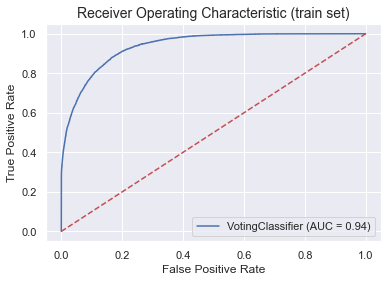

In [87]:
plot_roc_curve(v_clf_boost, X_train, y_train)
plt.title('Receiver Operating Characteristic (train set)',fontsize=14)
plt.plot([0,1],[0,1],'r--')

### Voting Classifier - Test Error

In [88]:
v_test_predictions = v_clf_boost.predict(X_test)
v_test_probabs = v_clf_boost.predict_proba(X_test)

# Printing out the Classification report

print(classification_report(y_test,v_test_predictions))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7460
           1       0.78      0.64      0.70      2309

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769



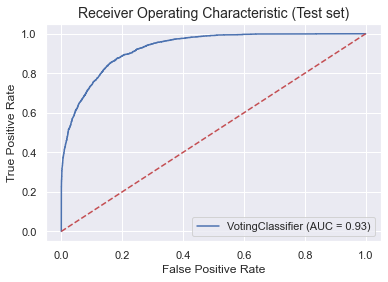

In [89]:
plot_roc_curve(v_clf_boost, X_test, y_test)
plt.title('Receiver Operating Characteristic (Test set)',fontsize=14)
plt.plot([0,1],[0,1],'r--')

In [90]:
train_accuracy = np.round(100*accuracy_score(y_train, v_train_predictions),2)
test_accuracy = np.round(100*accuracy_score(y_test, v_test_predictions),2)
train_auc = np.round(roc_auc_score(y_train,v_train_probabs[:,1]),2)
test_auc = np.round(roc_auc_score(y_test,v_test_probabs[:,1]),2)

print('VOTING CLASSIFIER SUMMARY:')
print('Train set accuracy: ', train_accuracy, '%')
print('Test set accuracy: ', test_accuracy, '%')
print('Train set AUC: ', train_auc)
print('Test set AUC: ', test_auc)

VOTING CLASSIFIER SUMMARY:
Train set accuracy:  87.98 %
Test set accuracy:  87.2 %
Train set AUC:  0.94
Test set AUC:  0.93


### Gradient Boosting - Train Error

In [91]:
gb_train_predictions = gb_clf_gridsearch.predict(X_train)
gb_train_probabs = gb_clf_gridsearch.predict_proba(X_train)

# Printing out the Classification report

print(classification_report(y_train,gb_train_predictions))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     29695
           1       0.79      0.65      0.72      9378

    accuracy                           0.88     39073
   macro avg       0.84      0.80      0.82     39073
weighted avg       0.87      0.88      0.87     39073



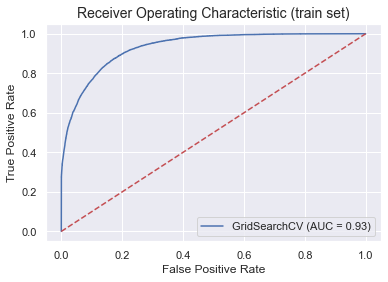

In [92]:
plot_roc_curve(gb_clf_gridsearch, X_train, y_train)
plt.title('Receiver Operating Characteristic (train set)',fontsize=14)
plt.plot([0,1],[0,1],'r--')

It's time to confirm that the algorithm works well by generalizing it to data it has never seen before - the test set.

### Gradient Boosting - Test Error

In [93]:
gb_test_predictions = gb_clf_gridsearch.predict(X_test)
gb_test_probabs = gb_clf_gridsearch.predict_proba(X_test)

# Printing out the Classification report

print(classification_report(y_test,gb_test_predictions))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7460
           1       0.77      0.64      0.70      2309

    accuracy                           0.87      9769
   macro avg       0.83      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769



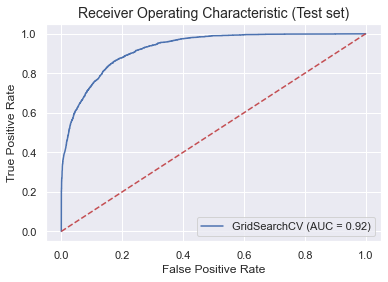

In [94]:
plot_roc_curve(gb_clf_gridsearch, X_test, y_test)
plt.title('Receiver Operating Characteristic (Test set)',fontsize=14)
plt.plot([0,1],[0,1],'r--')

In [95]:
train_accuracy = np.round(100*accuracy_score(y_train, gb_train_predictions),2)
test_accuracy = np.round(100*accuracy_score(y_test, gb_test_predictions),2)
train_auc = np.round(roc_auc_score(y_train,gb_train_probabs[:,1]),2)
test_auc = np.round(roc_auc_score(y_test,gb_test_probabs[:,1]),2)

print('GRADIENT BOOSTING CLASSIFIER SUMMARY:')
print('Train set accuracy: ', train_accuracy, '%')
print('Test set accuracy: ', test_accuracy, '%')
print('Train set AUC: ', train_auc)
print('Test set AUC: ', test_auc)

GRADIENT BOOSTING CLASSIFIER SUMMARY:
Train set accuracy:  87.58 %
Test set accuracy:  87.09 %
Train set AUC:  0.93
Test set AUC:  0.92


As demonstrated above, the algorithm performs very similarly on the train and test set. That's a sign it doesn't overfit the training data. 

Both the voting classifier and Gradient Boosting perform very similarly. Due to the fact that for Gradient Boosting less computational power is required, it might be the better pick here.

<a id='feature_importance'></a>

# Feature importance

Before ending the project, it's a good idea to look into the relative importances that different models assigned to different features. This might help us get better insight into the data. This, in turn, might point us in the right direction when collecting further data - we could focus more on the most important data (perhaps split it even further into more different categories) and we could also stop collecting data that's not indicative of what we're trying to predict.

I will take a look at the feature importances assigned by Gradient Boosting and XGBoost.

## Gradient Boosting

In [96]:
print('TOP 10 MOST IMPORTANT FEATURES FOR GRADIENT BOOSTING:')
feature_importance_gb = pd.DataFrame(zip(X_test.columns, gb_clf_gridsearch.best_estimator_.feature_importances_),columns=['Feature','Importance'])
feature_importance_gb.sort_values(by='Importance',ascending=False).head(10)

TOP 10 MOST IMPORTANT FEATURES FOR GRADIENT BOOSTING:


,Feature,Importance
9,Married-spouse-absent,0.391551
39,Capital-gain,0.201491
38,Education-num,0.192600
40,Capital-loss,0.062423
36,Age,0.054042
41,Hours-per-week,0.040536
12,Office,0.015742
16,Unknown-Occupation,0.007756
37,fnlwgt,0.007529
15,Service,0.004794


## XGBoost

In [97]:
print('TOP 10 MOST IMPORTANT FEATURES FOR XGBOOST:')
feature_importance_xgb = pd.DataFrame(zip(X_test.columns, xgb_clf_gridsearch.best_estimator_.feature_importances_),columns=['Feature','Importance'])
feature_importance_xgb.sort_values(by='Importance',ascending=False).head(10)

TOP 10 MOST IMPORTANT FEATURES FOR XGBOOST:


,Feature,Importance
9,Married-spouse-absent,0.568224
38,Education-num,0.065735
39,Capital-gain,0.045104
16,Unknown-Occupation,0.034431
21,Own-child,0.030593
40,Capital-loss,0.022036
29,Sex,0.020610
12,Office,0.019411
36,Age,0.017743
14,Professional,0.015699


Another way of checking how each feature contributed to the final prediction of the income is to check the correlation matrix.

In [98]:
print('FEATURES CORRELATING WITH INCOME:')
features_corr = train_test_bin_encoded.corr()['Income'].sort_values(ascending=False)[1:]
features_corr

FEATURES CORRELATING WITH INCOME:


 Married-spouse-absent    0.446292
 Not-in-family            0.403791
Sex                       0.214628
Service                   0.188793
Professional              0.182664
 Other-relative           0.120484
Unknown-Workclass         0.103570
 Other                    0.083710
Education                 0.080091
Self-emp                  0.063509
South-America             0.032551
Manual                    0.025167
USA                       0.016767
North-America             0.016599
 Black                    0.012587
Europe                    0.005459
 Private                 -0.010323
 Amer-Indian-Eskimo      -0.024920
 White                   -0.028247
 Never-married           -0.039303
Unknown-Country          -0.042688
Asia                     -0.057464
Separated                -0.065050
Government               -0.075625
Non-worker               -0.083567
Military                 -0.083921
 Wife                    -0.085601
Admin                    -0.086475
 Asian-Pac-Islander 

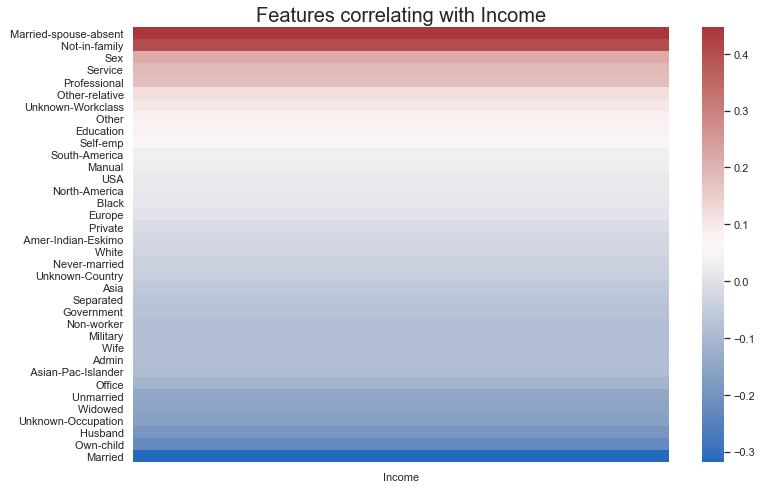

In [99]:
plt.figure(figsize=(12,8))
plt.title('Features correlating with Income',fontsize=20)
sns.heatmap(pd.DataFrame(features_corr),cmap='vlag')

Keep in mind that in the case of correlation values closest to 0 should are negligible while large values - both positive AND NEGATIVE are key. We can see here that some of the important features correlating with Income seem to be:


**POSITIVE CORRELATION (1 tends to correspond to Income > 50K, 0 tends to correspond to Income < 50K)**

Married-spouse-absent
Not-in-family
Sex

**NEGATIVE CORRELATION (1 tends to correspond to Income < 50 K, 0 tends to correspond to Income > 50K)**

Married
Own-child

<a id='possible'></a>

# Is it possible to improve the model? And how?

Because the model performs very similarly on the training and test set, it doesn't overfit the data so high variance is not a problem here. The steps that could be taken are steps used in a high bias situation (though to be honest the evaluation metrics are not that bad so it's not like we're dealing with a serious high bias/underfitting issue here). 

Some of the steps that can be taken to improve the model's performance are:


* Get more elaborate features. Create new, meaningful ones by combining or splitting the existing ones.

* Get rid of the features that don't matter that much.

* Try getting polynomial features.

* Try a wider range of the regularization parameter, namely try decreasing the regularization (in the case of GradientBoosting this means INCREASING the C hyperparameter).

Thanks for checking out my project!  :) 

~ Jakub

________________________________

*(If you want to work with me, check out my LinkedIn:
https://www.linkedin.com/in/jakub-gil/ or drop me an e-mail! jakubgil.poczta@gmail.com)*